In [51]:
from __future__ import print_function
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

import cntk as C
import cntk.tests.test_utils
C.cntk_py.set_fixed_random_seed(1)

%matplotlib inline

In [52]:
input_dim = 784
num_output_classes = 10

In [53]:
def create_reader(path, is_training, input_dim, num_output_classes):
    
    label_stream = C.io.StreamDef(field='labels', shape=num_output_classes, is_sparse=False)
    feature_stream = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
    
    desirelizer = C.io.CTFDeserializer(path, C.io.StreamDefs(labels=label_stream, features=feature_stream))
    
    return C.io.MinibatchSource(desirelizer,
                               randomize=is_training, max_sweeps=C.io.INFINITELY_REPEAT if is_training else 1)

In [54]:
data_found = False

for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                os.path.join("data", "MNIST")]:
    train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file = os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found = True
        break
        
if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")
    
print("Data directory is {0}".format(data_dir))

Data directory is data\MNIST


In [55]:
input = C.input_variable(input_dim)
label = C.input_variable(num_output_classes)

In [58]:
def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform()):
        r = C.layers.Dense(num_output_classes, activation=None)(features)
        
    return r

In [59]:
z = create_model(input)

In [60]:
loss = C.cross_entropy_with_softmax(z, label)

In [61]:
label_error = C.classification_error(z, label)

In [62]:
learning_rate = 0.2
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, label_error), [learner])

In [63]:
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]

def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"
    
    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose:
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
            
    return mb, training_loss, eval_error
        

In [64]:
minibatch_size = 64
num_samples_per_sweep = 60000
num_sweep_to_train_with = 10
num_minibatches_to_train = (num_samples_per_sweep * num_sweep_to_train_with) / minibatch_size

In [67]:
reader_train = create_reader(train_file, True, input_dim, num_output_classes)

input_map = {
    label: reader_train.streams.labels,
    input: reader_train.streams.features
}

training_progress_output_freq = 500

plotdata = {"batchsize":[], "loss": [], "error": []}

for i in range(0, int(num_minibatches_to_train)):
    data = reader_train.next_minibatch(minibatch_size, input_map=input_map)
    
    trainer.train_minibatch(data)
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 568.0889, Error: 4.69%
Minibatch: 500, Loss: 4062.8096, Error: 12.50%
Minibatch: 1000, Loss: 4331.8550, Error: 14.06%
Minibatch: 1500, Loss: 3663.3496, Error: 14.06%
Minibatch: 2000, Loss: 804.8766, Error: 4.69%
Minibatch: 2500, Loss: 1189.6134, Error: 4.69%
Minibatch: 3000, Loss: 1667.4829, Error: 7.81%
Minibatch: 3500, Loss: 3881.6699, Error: 18.75%
Minibatch: 4000, Loss: 9350.0586, Error: 26.56%
Minibatch: 4500, Loss: 1758.4890, Error: 9.38%
Minibatch: 5000, Loss: 2002.5848, Error: 7.81%
Minibatch: 5500, Loss: 1379.1532, Error: 7.81%
Minibatch: 6000, Loss: 2052.5754, Error: 9.38%
Minibatch: 6500, Loss: 6049.7031, Error: 25.00%
Minibatch: 7000, Loss: 285.3033, Error: 3.12%
Minibatch: 7500, Loss: 3884.6013, Error: 15.62%
Minibatch: 8000, Loss: 712.7651, Error: 3.12%
Minibatch: 8500, Loss: 679.2733, Error: 6.25%
Minibatch: 9000, Loss: 1611.7966, Error: 12.50%


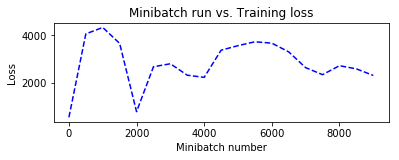

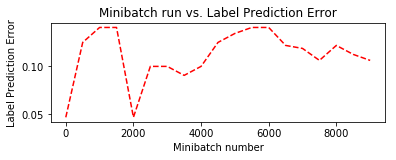

In [68]:
# Compute the moving average loss to smooth out the noise in SGD
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Plot the training loss and the training error
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

In [78]:
reader_test = create_reader(test_file, False, input_dim, num_output_classes)

test_input_map = {
    label  : reader_test.streams.labels,
    input  : reader_test.streams.features,
}

# Test data for trained model
test_minibatch_size = 512
num_samples = 10000
num_minibatches_to_test = num_samples // test_minibatch_size
test_result = 0.0

for i in range(num_minibatches_to_test):
    
    # We are loading test data in batches specified by test_minibatch_size
    # Each data point in the minibatch is a MNIST digit image of 784 dimensions 
    # with one pixel per dimension that we will encode / decode with the 
    # trained model.
    data = reader_test.next_minibatch(test_minibatch_size,
                                      input_map = test_input_map)

    eval_error = trainer.test_minibatch(data)
    test_result = test_result + eval_error

# Average of evaluation errors of all test minibatches
print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

Average test error: 10.03%


In [83]:
reader_test = create_reader(test_file, False, input_dim, num_output_classes)

test_input_map = {
    label  : reader_test.streams.labels,
    input  : reader_test.streams.features,
}

test_minibatch_size = 512
num_samples = 10000
num_minibatches_to_test = num_samples // test_minibatch_size
test_result = 0.0

for i in range(num_minibatches_to_test):
    data = reader_test.next_minibatch(test_minibatch_size,
                                      input_map = test_input_map)

    eval_error = trainer.test_minibatch(data)
    test_result = test_result + eval_error

# Average of evaluation errors of all test minibatches
print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))
    

Average test error: 10.03%


In [84]:
out = C.softmax(z)

In [86]:
eval_reader = create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 25
eval_input_map = {input : eval_reader.streams.features}

data = reader_test.next_minibatch(eval_minibatch_size, input_map=test_input_map)
img_label = data[label].asarray()
img_data = data[input].asarray()

predicted_label_prop = [out.eval(img_data[i]) for i in range(len(img_data))]

In [87]:
pred = [np.argmax(predicted_label_prop[i]) for i in range(len(predicted_label_prop))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]

In [88]:
print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [0, 5, 8, 6, 0, 3, 8, 1, 0, 3, 0, 4, 7, 4, 9, 2, 9, 5, 7, 1, 7, 1, 6, 6, 5]
Predicted: [0, 5, 8, 6, 0, 3, 8, 1, 0, 3, 0, 9, 7, 4, 9, 0, 9, 0, 7, 1, 7, 1, 6, 6, 0]


Image Label:  3


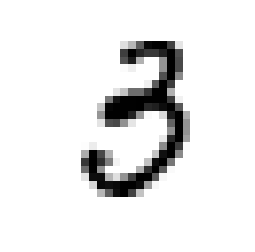

In [89]:
sample_number = 5
plt.imshow(img_data[sample_number].reshape(28,28), cmap="gray_r")
plt.axis('off')

img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)